In [5]:
!pip3 install openai python-dotenv opencv-python matplotlib requests flask

In [6]:
!pip3 install -U scikit-learn

In [7]:
# import required packages

from openai import OpenAI

import os
from dotenv import load_dotenv
from IPython.display import display, Image, Audio

import cv2 as opencv # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import json

from flask import Flask, request, jsonify
import numpy as np
from sklearn.cluster import KMeans


# load env file
load_dotenv()

# Load OpenAI API client
client = OpenAI()

# load Flask
app = Flask(__name__)

# Extract frames from a video in base64format

In [8]:
video = opencv.VideoCapture("sample.mp4")

base64Frames = []

while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = opencv.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

step = 50
sampledFrames = base64Frames[::step]
print(len(sampledFrames), "sampled frames read.")

181 frames read.
4 sampled frames read.


## Display a sample frame in base64 format

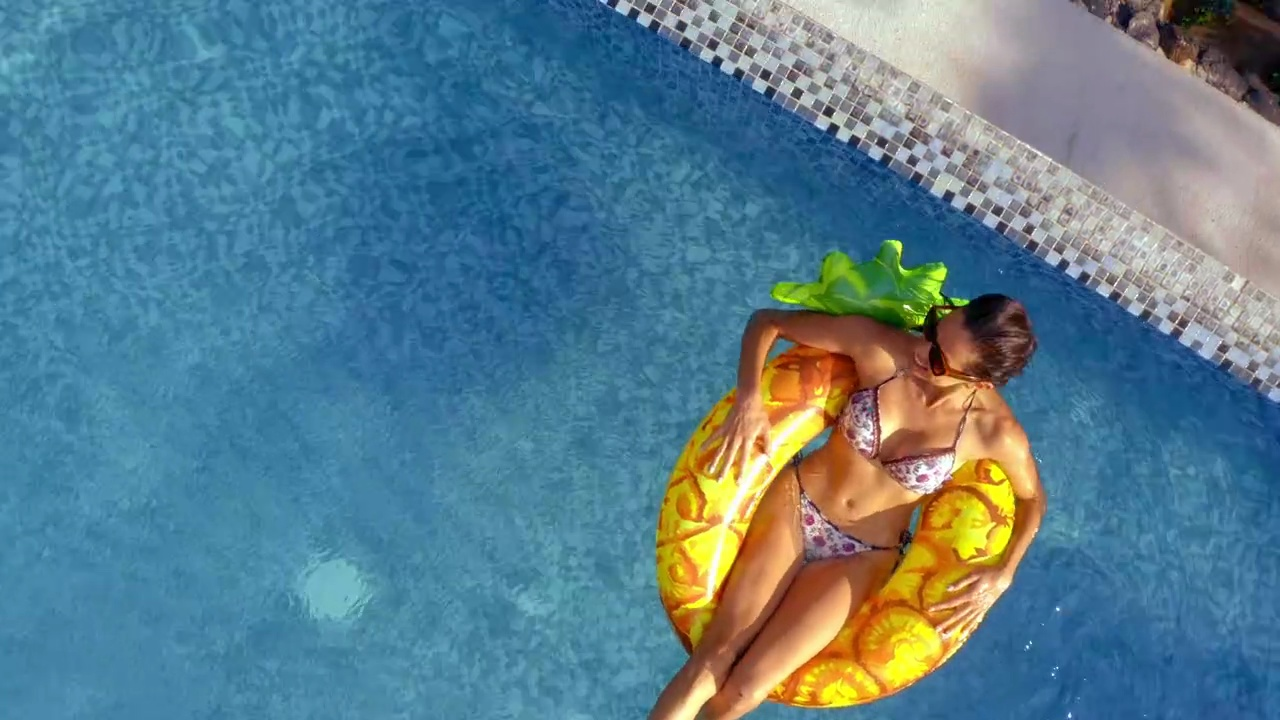

In [9]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    # time.sleep(0.025)

## Analyze image content

### Scoring Image clarity:
resource: https://medium.com/engineering-housing/image-scoring-allocating-percentage-score-to-images-for-their-quality-6169abbf850e

Laplacian Operator:
https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html?source=post_page-----6169abbf850e--------------------------------

In [10]:
import matplotlib.pyplot as plt

def analyze_image_content(image_path):
    # Read image
    image = opencv.imread(image_path) # return numpy array contatining values for the image
    
    # Analyze colors
    def get_dominant_colors(image, k=3):
        image = opencv.cvtColor(image, opencv.COLOR_BGR2RGB)
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(pixels)
        colors = kmeans.cluster_centers_
        return [f"#{int(color[0]):02x}{int(color[1]):02x}{int(color[2]):02x}" for color in colors]
    
    dominant_colors = get_dominant_colors(image)
    
    # Analyze objects using OpenCV's built-in object detector
    def get_objects(image):
        gray = opencv.cvtColor(image, opencv.COLOR_BGR2GRAY)
        detector = opencv.SimpleBlobDetector_create()
        keypoints = detector.detect(gray)
        points = [(kp.pt, kp.size) for kp in keypoints]

        # plotting image 
        # output_image = opencv.drawKeypoints(gray, keypoints, 0, (0, 0, 255), 
        # flags=opencv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS) 
        # plt.imshow(output_image) 
        # plt.show() 
        return points
        
    objects_detected = get_objects(image)


    def count_objects(image):
        gray = opencv.cvtColor(image, opencv.COLOR_BGR2GRAY)
        detector = opencv.SimpleBlobDetector_create()
        keypoints = detector.detect(gray)
        return len(keypoints)
    
    object_count = count_objects(image)
    
    # Analyze brightness
    def get_brightness(image):
        hsv = opencv.cvtColor(image, opencv.COLOR_BGR2HSV)
        _, _, v = opencv.split(hsv)
        return np.mean(v)
    
    brightness = get_brightness(image)
    # brightness_label = "bright" if brightness > 127 else "dark"
    brightness_level = float(np.round(brightness / 255, decimals=4))
    
    # Analyze edges using canny edge detection
    def analyze_edges_using_canny(image):
        gray = opencv.cvtColor(image, opencv.COLOR_BGR2GRAY)
        edges = opencv.Canny(gray, 100, 200)
        edge_percentage = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
        return float(edge_percentage)
        
    detail_level_with_canny = analyze_edges_using_canny(image)

    # analyze edges using laplacian with normalized image
    def normalize_image(image):
        normalized = opencv.normalize(image, None, 0, 255, opencv.NORM_MINMAX)
        return normalized.astype(np.uint8)
    
    normalized_image = normalize_image(image)

    def analyze_edge_using_laplacian(image):
        gray = opencv.cvtColor(image, opencv.COLOR_BGR2GRAY)
        laplacian = opencv.Laplacian(gray, opencv.CV_64F)
        variance = laplacian.var()
        return variance
    
    detail_level_with_laplacian = float(analyze_edge_using_laplacian(normalized_image))    

    # Detect faces (if any)
    def detect_faces(image):
        gray = opencv.cvtColor(image, opencv.COLOR_BGR2GRAY)
        face_cascade = opencv.CascadeClassifier(opencv.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        return len(faces)
    
    face_count = detect_faces(image)
    
    return {
        "dominant_colors": dominant_colors,
        "object_detected": objects_detected,
        "object_count": object_count,
        "brightness": brightness_level,
        "detail_level": detail_level_with_laplacian,
        "face_count": face_count
    }

## Generate feedback

In [11]:
def generate_feedback(image_analysis):
    feedback = f"Your image appears to be {image_analysis['brightness']} with {image_analysis['detail_level']}. "
    feedback += f"The dominant colors are {', '.join(image_analysis['dominant_colors'])}. "
    feedback += f"I detected approximately {image_analysis['object_count']} distinct elements in the image. "
    if image_analysis['face_count'] > 0:
        feedback += f"The image contains {image_analysis['face_count']} face(s)."
    return feedback

def generate_design_recommendations(image_analysis):
    recommendations = {
        "color_palette": image_analysis['dominant_colors'],
        "visual_treatment": "Consider adding contrast" if image_analysis['brightness'] == "dark" else "Try softening highlights",
        "composition": "The image seems busy" if image_analysis['object_count'] > 10 else "The composition looks balanced",
        "focus": "Consider simplifying the image" if image_analysis['detail_level'] == "high detail" else "Try adding more points of interest"
    }
    if image_analysis['face_count'] > 0:
        recommendations["portrait_mode"] = "Consider using portrait mode or blurring the background to emphasize the face(s)"
    return recommendations

## Analyze photos

In [12]:
def analyze_photo(path):
    # Analyze image
    image_analysis = analyze_image_content(path)
    return image_analysis

In [13]:
def analyze_photos(base64_frames, step=1):
    contents = []
    for frame in base64_frames[::step]:

        # Download and save image to a temporary file
        image_path = f"temp_image_{len(frame)}.jpg"
        with open(image_path, "wb") as f:
            f.write(base64.b64decode(frame.encode("utf-8")))
        image_analysis = analyze_image_content(image_path)

        # append the image analysis to the list
        contents.append(image_analysis)

        os.remove(image_path)
    return contents

In [14]:
analysis = analyze_photos(base64Frames, step)
analysis

[{'dominant_colors': ['#3c7a9d', '#e7c35e', '#875227'],
  'object_detected': [((637.1889038085938, 246.21824645996094),
    8.798958778381348),
   ((694.8843994140625, 313.00555419921875), 10.479125022888184),
   ((621.0665283203125, 186.98358154296875), 12.859246253967285)],
  'object_count': 3,
  'brightness': 0.6404,
  'detail_level': 154.31210821171052,
  'face_count': 0},
 {'dominant_colors': ['#39779c', '#875226', '#e7c15b'],
  'object_detected': [((680.9940185546875, 266.43798828125),
    9.407444953918457),
   ((404.74066162109375, 171.6066436767578), 7.810793399810791),
   ((652.28369140625, 232.93653869628906), 8.661109924316406)],
  'object_count': 3,
  'brightness': 0.6359,
  'detail_level': 77.38384527842204,
  'face_count': 0},
 {'dominant_colors': ['#4583a2', '#c79840', '#28628d'],
  'object_detected': [((712.4082641601562, 366.035888671875),
    11.77428913116455),
   ((671.9891357421875, 344.7506408691406), 7.83760404586792),
   ((670.3804931640625, 287.1706237792969),

In [15]:
# format analysis to a string representation
formatted_analysis = json.dumps(analysis)
formatted_analysis

'[{"dominant_colors": ["#3c7a9d", "#e7c35e", "#875227"], "object_detected": [[[637.1889038085938, 246.21824645996094], 8.798958778381348], [[694.8843994140625, 313.00555419921875], 10.479125022888184], [[621.0665283203125, 186.98358154296875], 12.859246253967285]], "object_count": 3, "brightness": 0.6404, "detail_level": 154.31210821171052, "face_count": 0}, {"dominant_colors": ["#39779c", "#875226", "#e7c15b"], "object_detected": [[[680.9940185546875, 266.43798828125], 9.407444953918457], [[404.74066162109375, 171.6066436767578], 7.810793399810791], [[652.28369140625, 232.93653869628906], 8.661109924316406]], "object_count": 3, "brightness": 0.6359, "detail_level": 77.38384527842204, "face_count": 0}, {"dominant_colors": ["#4583a2", "#c79840", "#28628d"], "object_detected": [[[712.4082641601562, 366.035888671875], 11.77428913116455], [[671.9891357421875, 344.7506408691406], 7.83760404586792], [[670.3804931640625, 287.1706237792969], 7.9849324226379395]], "object_count": 3, "brightness

## Ask Chatgpt to analyze the photos

In [16]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            """These are frames from a video and some preprocessed analysis on each frame.
            Take a step by step process and analyze the design composition of the video. 
            Think about how the main objects are placed, 
            the relationship between them, and the overall aesthetic of the video. 
            Do a complete color analysis bsed on the dominant colors.
            """,
            *map(lambda x: {"image": x, "resize": 768}, sampledFrames),
            formatted_analysis,
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 1200,
}

result = client.chat.completions.create(**params)



In [17]:
print(result.choices[0].message.content)

result_content = result.choices[0].message.content

### Step-by-Step Analysis of Design Composition

1. **Object Placement and Relationship:**
    - The main object in each frame is a person lounging on a yellow-orange pineapple-shaped float in a swimming pool.
    - In the first frame, the person is centered both vertically and horizontally, creating a symmetrical and balanced composition. The float's leafy green top adds interest and breaks the symmetry just enough to keep it visually engaging.
    - The second frame shows a slight change in perspective. The person and float have slightly moved towards the left side of the frame. However, they remain centrally prominent, still maintaining balance.
    - In the third frame, the perspective rotates and the person and float are slightly more to the right, highlighting the dynamic motion within the video.
    - By the fourth frame, the person is positioned in the bottom left-hand quadrant, likely indicating the motion is towards the swimming pool edge, adding a sense of direction and prog

## Ask Chatgpt to make recommendations for the videos/photos

In [26]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            """These are frames from a video and some preprocessed analysis on each frame.
            You are an expert in design. Make a recommendation on the creating an engaging
            design elements like font suggestions, color palette suggestions, and visual treatment suggestions.
            """,
            result_content,
            *map(lambda x: {"image": x, "resize": 768}, sampledFrames),
            formatted_analysis,
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 1200,
}

recommendation = client.chat.completions.create(**params)

In [27]:
print(recommendation.choices[0].message.content)

recommendation_content = recommendation.choices[0].message.content

### Engaging Design Element Recommendations

Given the vibrant and summery aesthetic depicted in these video frames along with the detailed analysis provided, here are my recommendations for creating engaging design elements:

#### Font Suggestions:
1. **Primary Font:**
   - **Name:** *Bariol*
   - **Type:** Sans-serif
   - **Reason:** Bariol has a rounded and friendly feel, which complements the relaxing and fun atmosphere depicted. Its readability is high even on vibrant backgrounds.
   
2. **Secondary Font:**
   - **Name:** *Futura*
   - **Type:** Geometric Sans-serif
   - **Reason:** Futura’s clean and modern design can provide a contrasting yet harmonizing effect when paired with the primary font. It is suitable for headings or emphasis points.

#### Color Palette Suggestions:
The current composition already utilizes a beautiful contrast of warm and cool tones. Here are my suggested colors to expand upon this:

1. **Primary Colors:**
   - **Sunset Yellow (#FFC300):** For warmth an